In [1]:
import os
import shutil
import random

# ====== Đường dẫn thư mục gốc ======
dataset_dir = "clean_dataset"   # vì code và data cùng thư mục
base_dir = "dataset_split"      # thư mục đích để lưu train/val/test

# ====== Tạo 3 thư mục ======
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# ====== Tỉ lệ chia ======
train_split = 0.7
val_split = 0.2
test_split = 0.1

# ====== Hàm lọc file ảnh ======
def is_image_file(filename):
    valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    return filename.lower().endswith(valid_exts)

# ====== Chia dữ liệu ======
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if is_image_file(f)]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_split * n_total)
    n_val = int(val_split * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]

    for subset_name, subset_imgs in zip(
        ["train", "val", "test"],
        [train_imgs, val_imgs, test_imgs]
    ):
        dest_dir = os.path.join(base_dir, subset_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for img in subset_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(dest_dir, img))

print("✅ Chia dữ liệu thành công!")


✅ Chia dữ liệu thành công!


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Đường dẫn mới theo code của bạn
base_dir = "dataset_split"
train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")

# Kiểm tra xem các thư mục đã được tạo chưa
print("🔍 Kiểm tra cấu trúc thư mục:")
for path in [train_path, val_path, test_path]:
    if os.path.exists(path):
        num_classes = len(os.listdir(path))
        print(f"✅ {path}: tồn tại, có {num_classes} lớp")
    else:
        print(f"❌ {path}: không tồn tại")

🔍 Kiểm tra cấu trúc thư mục:
✅ dataset_split\train: tồn tại, có 4 lớp
✅ dataset_split\val: tồn tại, có 4 lớp
✅ dataset_split\test: tồn tại, có 4 lớp


In [3]:
class StepByStepImageProcessor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.visualization_dir = os.path.join(base_dir, "processing_visualization")
        os.makedirs(self.visualization_dir, exist_ok=True)
    
    def process_single_image_with_steps(self, image_path, save_prefix="sample"):
        """
        Xử lý ảnh từng bước và lưu visualization
        """
        # BƯỚC 1: Đọc ảnh gốc
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            raise ValueError(f"Không thể đọc ảnh: {image_path}")
        
        original_height, original_width = img_bgr.shape[:2]
        
        # BƯỚC 2: Chuyển BGR sang RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # BƯỚC 3: Resize về kích thước mục tiêu
        img_resized = cv2.resize(img_rgb, self.target_size)
        
        # BƯỚC 4: Chuẩn hóa pixel values [0, 1]
        img_normalized = img_resized.astype('float32') / 255.0
        
        # BƯỚC 5: Tạo visualization
        self._create_processing_visualization(
            original_bgr=img_bgr,
            original_rgb=img_rgb,
            resized=img_resized,
            normalized=img_normalized,
            original_size=(original_width, original_height),
            save_prefix=save_prefix
        )
        
        return img_normalized
    
    def _create_processing_visualization(self, original_bgr, original_rgb, resized, normalized, 
                                       original_size, save_prefix):
        """
        Tạo visualization cho từng bước xử lý
        """
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('QUY TRÌNH XỬ LÝ ẢNH TỪNG BƯỚC', fontsize=16, fontweight='bold')
        
        # Hàng 1: Ảnh
        # 1.1 Ảnh gốc BGR (sẽ chuyển sang RGB để hiển thị)
        axes[0, 0].imshow(original_rgb)
        axes[0, 0].set_title(f'① ẢNH GỐC\n{original_size[0]}x{original_size[1]}')
        axes[0, 0].axis('off')
        
        # 1.2 Ảnh RGB
        axes[0, 1].imshow(original_rgb)
        axes[0, 1].set_title('② CHUYỂN RGB\n3 kênh màu')
        axes[0, 1].axis('off')
        
        # 1.3 Ảnh sau resize
        axes[0, 2].imshow(resized)
        axes[0, 2].set_title(f'③ RESIZE\n{self.target_size[0]}x{self.target_size[1]}')
        axes[0, 2].axis('off')
        
        # 1.4 Ảnh sau chuẩn hóa
        axes[0, 3].imshow(normalized)
        axes[0, 3].set_title('④ CHUẨN HÓA\n[0, 1] range')
        axes[0, 3].axis('off')
        
        # Hàng 2: Histograms
        # 2.1 Histogram ảnh gốc (RGB)
        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([original_rgb], [i], None, [256], [0, 256])
            axes[1, 0].plot(hist, color=color, alpha=0.7, label=f'{color.upper()}')
        axes[1, 0].set_title('Histogram Ảnh Gốc')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 2.2 Histogram sau resize
        for i, color in enumerate(colors):
            hist = cv2.calcHist([resized], [i], None, [256], [0, 256])
            axes[1, 1].plot(hist, color=color, alpha=0.7)
        axes[1, 1].set_title('Histogram Sau Resize')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 2.3 Histogram sau chuẩn hóa
        normalized_display = (normalized * 255).astype('uint8')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([normalized_display], [i], None, [256], [0, 256])
            axes[1, 2].plot(hist, color=color, alpha=0.7)
        axes[1, 2].set_title('Histogram Sau Chuẩn Hóa')
        axes[1, 2].grid(True, alpha=0.3)
        
        # 2.4 Thông tin thống kê
        stats_text = f"""
        THỐNG KÊ ẢNH:
        
        Kích thước gốc: {original_size[0]}x{original_size[1]}
        Kích thước sau resize: {self.target_size[0]}x{self.target_size[1]}
        
        Giá trị pixel:
        - Min: {normalized.min():.3f}
        - Max: {normalized.max():.3f}
        - Mean: {normalized.mean():.3f}
        - Std: {normalized.std():.3f}
        """
        axes[1, 3].text(0.1, 0.9, stats_text, transform=axes[1, 3].transAxes, 
                       fontsize=10, verticalalignment='top', fontfamily='monospace')
        axes[1, 3].set_title('Thông Tin Ảnh')
        axes[1, 3].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.visualization_dir, f'{save_prefix}_processing_steps.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✅ Đã lưu visualization: {save_prefix}_processing_steps.png")

# Khởi tạo processor
processor = StepByStepImageProcessor(target_size=(224, 224))

# Xử lý và visualize một vài ảnh mẫu từ mỗi class
print("\n🔍 Đang xử lý và visualize ảnh mẫu...")
sample_count = 0
for class_name in os.listdir(train_path):
    class_train_path = os.path.join(train_path, class_name)
    if os.path.exists(class_train_path):
        sample_images = [f for f in os.listdir(class_train_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:1]  # Lấy 1 ảnh mỗi class
        
        for sample_img in sample_images:
            sample_path = os.path.join(class_train_path, sample_img)
            try:
                processed_img = processor.process_single_image_with_steps(
                    sample_path, 
                    save_prefix=f"class_{class_name}_{sample_count}"
                )
                sample_count += 1
                print(f"✅ Đã xử lý ảnh mẫu: {class_name}/{sample_img}")
            except Exception as e:
                print(f"❌ Lỗi xử lý {sample_img}: {e}")


🔍 Đang xử lý và visualize ảnh mẫu...


C:\Users\letra\AppData\Local\Temp\ipykernel_2260\3937458365.py:111: UserWarning: Glyph 7888 (\N{LATIN CAPITAL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\letra\AppData\Local\Temp\ipykernel_2260\3937458365.py:111: UserWarning: Glyph 7842 (\N{LATIN CAPITAL LETTER A WITH HOOK ABOVE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\letra\AppData\Local\Temp\ipykernel_2260\3937458365.py:111: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\letra\AppData\Local\Temp\ipykernel_2260\3937458365.py:112: UserWarning: Glyph 7888 (\N{LATIN CAPITAL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(os.path.join(self.visualization_dir, f'{save_prefix}_processing_steps.png'),
C:\Users\letra\AppData\Local\Temp\ipykernel_2260\3937458365.py:112: UserWarning: Glyph 7842 (\N{LATIN CAPITAL LETT

✅ Đã lưu visualization: class_Apple___Apple_scab_0_processing_steps.png
✅ Đã xử lý ảnh mẫu: Apple___Apple_scab/image__1000_.JPG
✅ Đã lưu visualization: class_Apple___healthy_1_processing_steps.png
✅ Đã xử lý ảnh mẫu: Apple___healthy/image__1000_.JPG
✅ Đã lưu visualization: class_Corn___Common_rust_2_processing_steps.png
✅ Đã xử lý ảnh mẫu: Corn___Common_rust/image__1000_.JPG
✅ Đã lưu visualization: class_Corn___healthy_3_processing_steps.png
✅ Đã xử lý ảnh mẫu: Corn___healthy/image__1000_.jpg


In [4]:
def create_data_generators(batch_size=32):
    """
    Tạo data generators cho train, val, test với augmentation
    """
    # Data augmentation cho training
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Chuẩn hóa
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Không augmentation cho validation và test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Tạo generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    print("✅ Data generators đã được tạo:")
    print(f"   - Train: {train_generator.samples} ảnh, {len(train_generator.class_indices)} classes")
    print(f"   - Validation: {val_generator.samples} ảnh")
    print(f"   - Test: {test_generator.samples} ảnh")
    print(f"   - Class mapping: {train_generator.class_indices}")
    
    return train_generator, val_generator, test_generator

# Tạo data generators
batch_size = 32
train_gen, val_gen, test_gen = create_data_generators(batch_size)

Found 4987 images belonging to 4 classes.
Found 3377 images belonging to 4 classes.
Found 2060 images belonging to 4 classes.
✅ Data generators đã được tạo:
   - Train: 4987 ảnh, 4 classes
   - Validation: 3377 ảnh
   - Test: 2060 ảnh
   - Class mapping: {'Apple___Apple_scab': 0, 'Apple___healthy': 1, 'Corn___Common_rust': 2, 'Corn___healthy': 3}


✅ Mô hình B6 CNN đã được tạo!


Model: "B6_CNN_Plant_Disease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn1 (BatchNormalization) │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn2 (BatchNormalization) │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu2 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_dropout (Dropout)        │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn1 (BatchNormalization) │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu1 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn2 (BatchNormalization) │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_dropout (Dropout)        │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn1 (BatchNormalization) │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu1 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn2 (BatchNormalization) │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu2 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_dropout (Dropout)        │ (None, 28, 28, 256)    │             

 Total params: 16,635,716 (63.46 MB)

 Trainable params: 16,626,244 (63.42 MB)

 Non-trainable params: 9,472 (37.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


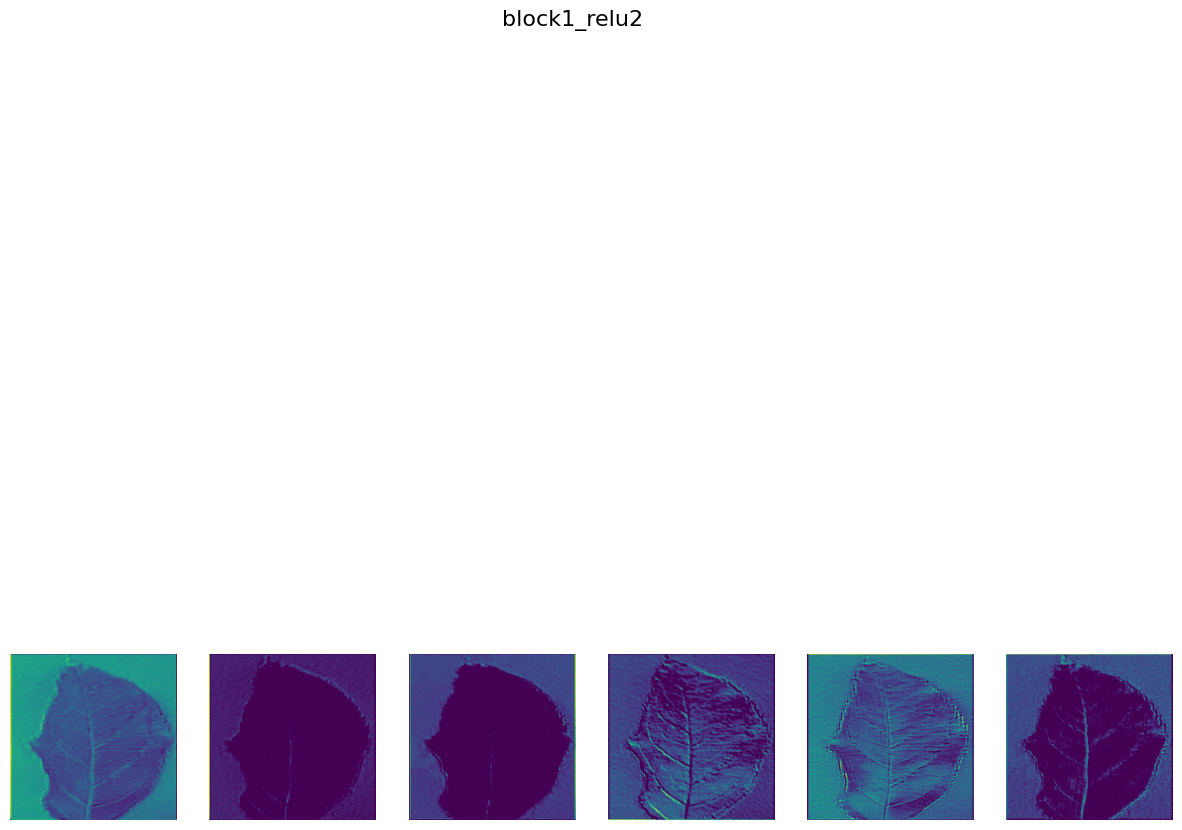

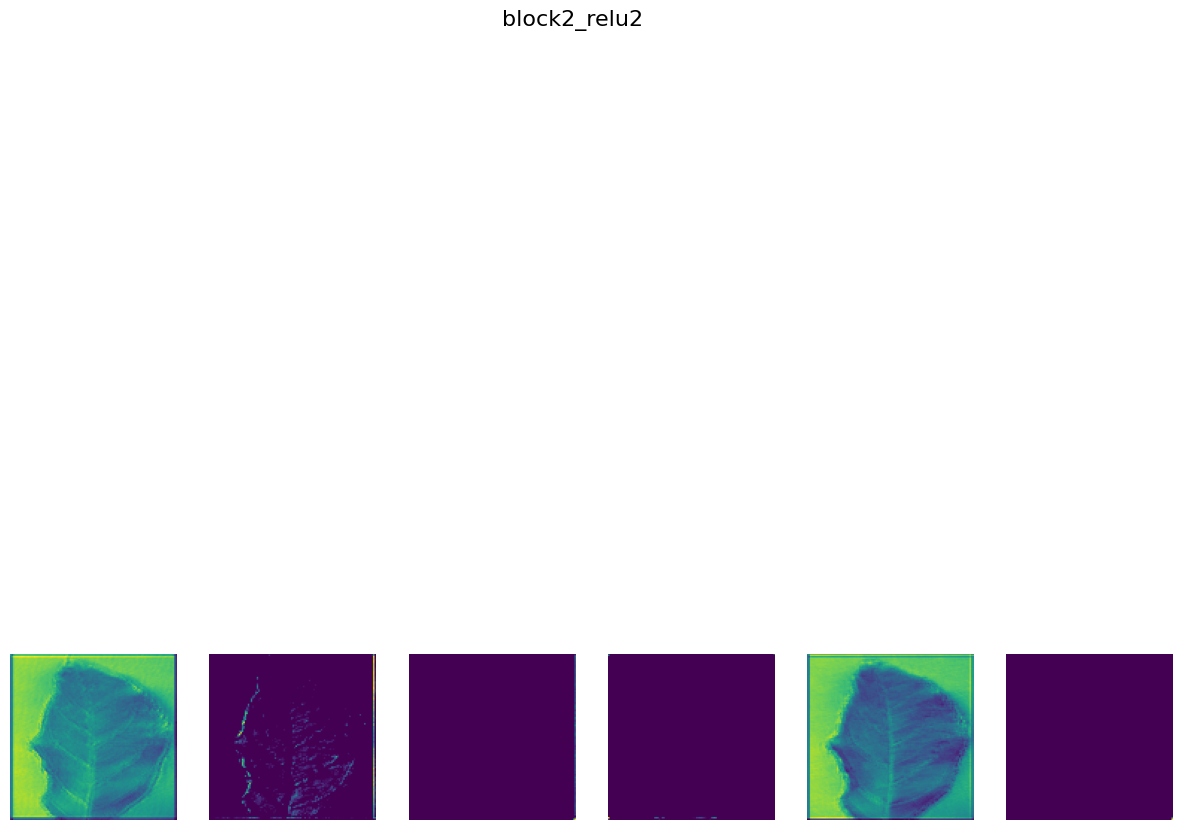

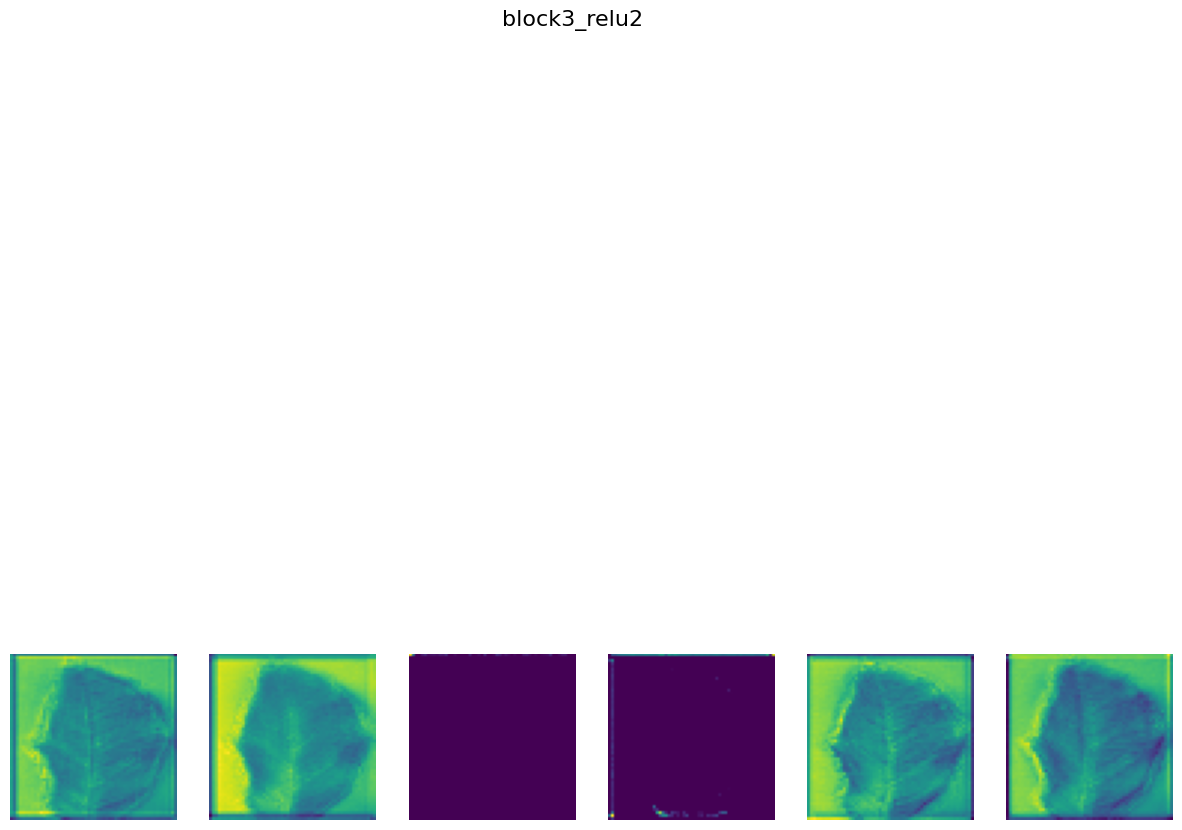

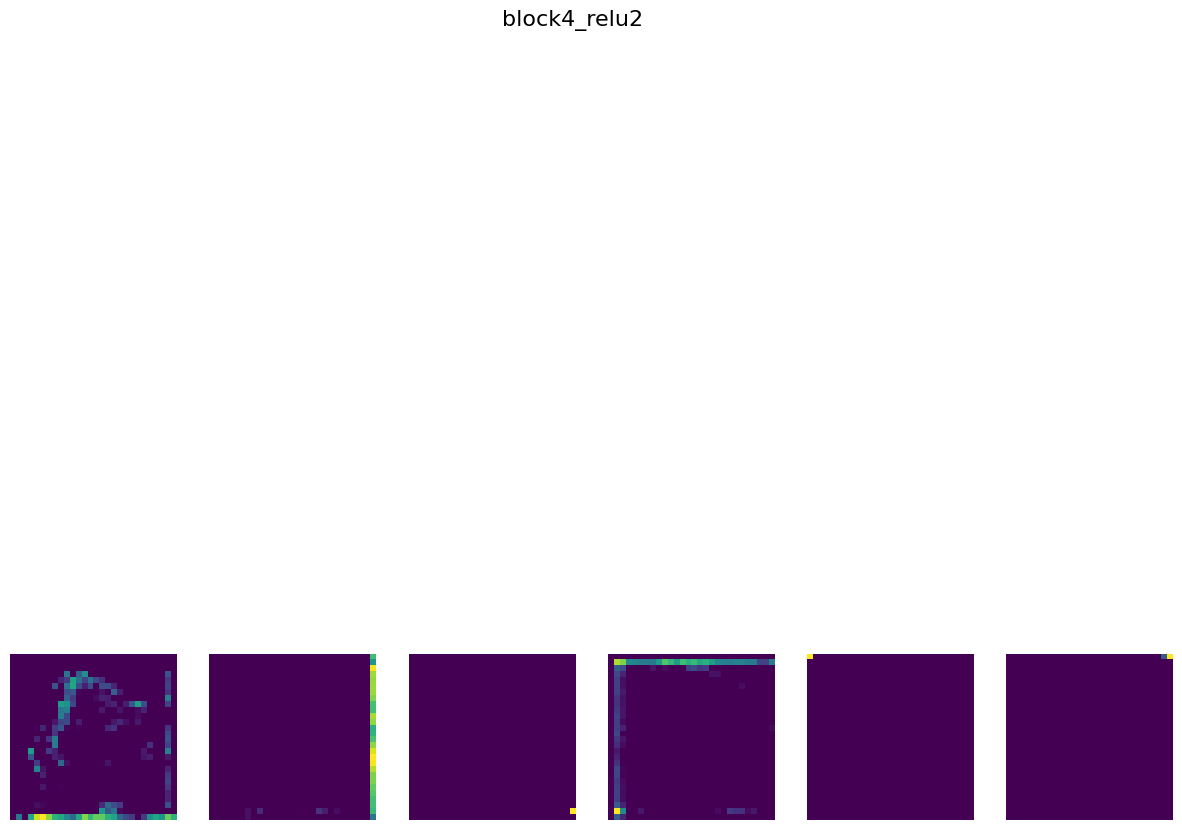

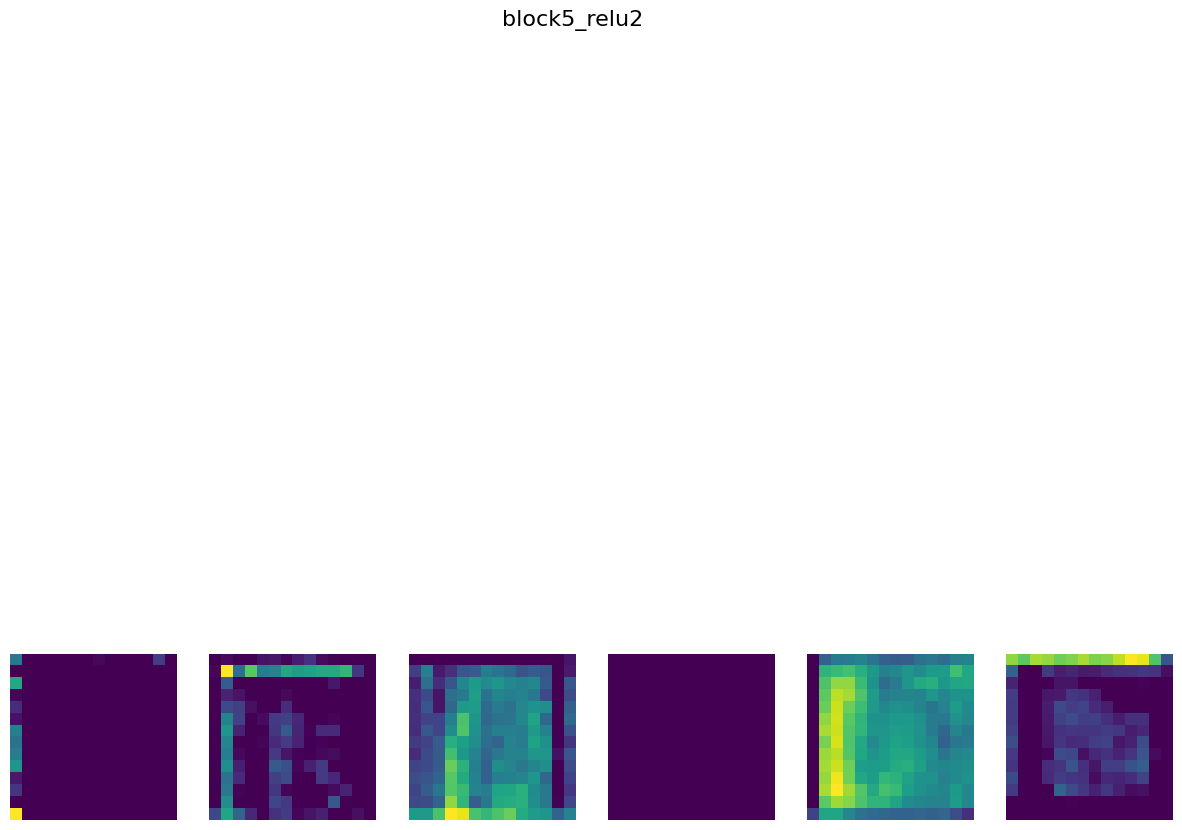

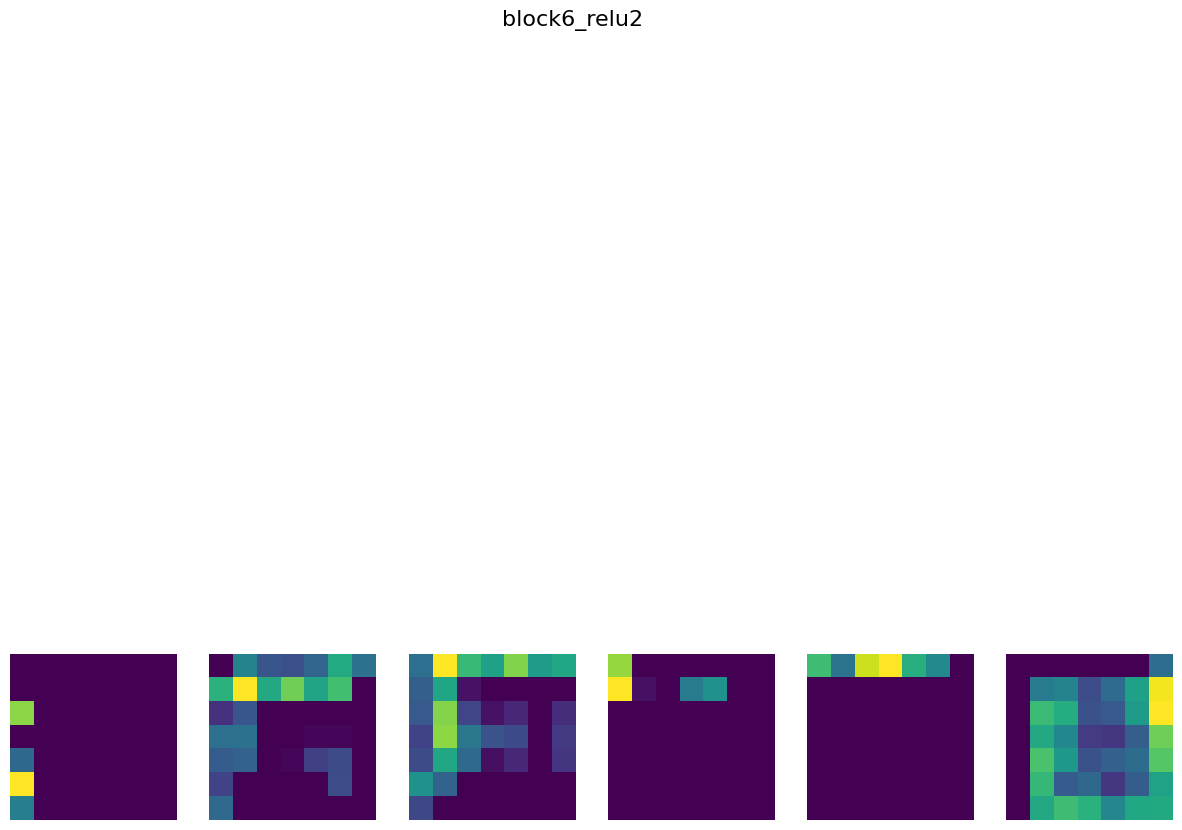

You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Đã lưu sơ đồ kiến trúc model: b6_cnn_architecture.png


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# ===== Hàm tạo model B6 CNN (Functional API) =====
def create_b6_cnn_model_functional(input_shape=(224,224,3), num_classes=4):
    inputs = Input(shape=input_shape, name='input_layer')
    
    # Block 1
    x = Conv2D(64, (3,3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization(name='block1_bn1')(x)
    x = Activation('relu', name='block1_relu1')(x)
    x = Conv2D(64, (3,3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization(name='block1_bn2')(x)
    x = Activation('relu', name='block1_relu2')(x)
    x = MaxPooling2D((2,2), name='block1_pool')(x)
    x = Dropout(0.25, name='block1_dropout')(x)
    
    # Block 2
    x = Conv2D(128, (3,3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization(name='block2_bn1')(x)
    x = Activation('relu', name='block2_relu1')(x)
    x = Conv2D(128, (3,3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization(name='block2_bn2')(x)
    x = Activation('relu', name='block2_relu2')(x)
    x = MaxPooling2D((2,2), name='block2_pool')(x)
    x = Dropout(0.25, name='block2_dropout')(x)
    
    # Block 3
    x = Conv2D(256, (3,3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization(name='block3_bn1')(x)
    x = Activation('relu', name='block3_relu1')(x)
    x = Conv2D(256, (3,3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization(name='block3_bn2')(x)
    x = Activation('relu', name='block3_relu2')(x)
    x = MaxPooling2D((2,2), name='block3_pool')(x)
    x = Dropout(0.25, name='block3_dropout')(x)
    
    # Block 4
    x = Conv2D(512, (3,3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Activation('relu', name='block4_relu1')(x)
    x = Conv2D(512, (3,3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Activation('relu', name='block4_relu2')(x)
    x = MaxPooling2D((2,2), name='block4_pool')(x)
    x = Dropout(0.25, name='block4_dropout')(x)
    
    # Block 5
    x = Conv2D(512, (3,3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Activation('relu', name='block5_relu1')(x)
    x = Conv2D(512, (3,3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Activation('relu', name='block5_relu2')(x)
    x = MaxPooling2D((2,2), name='block5_pool')(x)
    x = Dropout(0.25, name='block5_dropout')(x)
    
    # Block 6
    x = Conv2D(512, (3,3), padding='same', name='block6_conv1')(x)
    x = BatchNormalization(name='block6_bn1')(x)
    x = Activation('relu', name='block6_relu1')(x)
    x = Conv2D(512, (3,3), padding='same', name='block6_conv2')(x)
    x = BatchNormalization(name='block6_bn2')(x)
    x = Activation('relu', name='block6_relu2')(x)
    x = MaxPooling2D((2,2), name='block6_pool')(x)
    x = Dropout(0.5, name='block6_dropout')(x)
    
    # Fully Connected Layers
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = BatchNormalization(name='fc_bn1')(x)
    x = Dropout(0.5, name='fc_dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = BatchNormalization(name='fc_bn2')(x)
    x = Dropout(0.5, name='fc_dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="B6_CNN_Plant_Disease")
    return model

# ===== Tạo và compile model =====
num_classes = len(train_gen.class_indices)  # giữ nguyên
model = create_b6_cnn_model_functional(input_shape=(224,224,3), num_classes=num_classes)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Mô hình B6 CNN đã được tạo!")
model.summary()

# ===== Visualize feature maps =====
layer_names = [
    'block1_relu2', 'block2_relu2', 'block3_relu2',
    'block4_relu2', 'block5_relu2', 'block6_relu2'
]
feature_map_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])

# Chọn một ảnh để visualize
img_path = r'D:\testing\clean_dataset\Apple___Apple_scab\image__1_.JPG'  # chỉnh theo dataset
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

feature_maps = feature_map_model.predict(img_array)

# Vẽ feature maps
for fmap, name in zip(feature_maps, layer_names):
    n_features = fmap.shape[-1]
    display_features = min(6, n_features)
    fig, axes = plt.subplots(1, display_features, figsize=(15, 15))
    fig.suptitle(name, fontsize=16)
    for i in range(display_features):
        axes[i].imshow(fmap[0,:,:,i], cmap='viridis')
        axes[i].axis('off')
    plt.show()

# ===== Lưu sơ đồ kiến trúc model =====
base_dir = '/content/dataset_split'  # chỉnh theo nhu cầu
os.makedirs(base_dir, exist_ok=True)
plot_model(
    model,
    to_file=os.path.join(base_dir, 'b6_cnn_architecture.png'),
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)
print("✅ Đã lưu sơ đồ kiến trúc model: b6_cnn_architecture.png")


In [6]:
def train_b6_cnn_model():
    """
    Training mô hình B6 CNN với callbacks
    """
    # Callbacks
    checkpoint_path = os.path.join(base_dir, "best_b6_model.h5")
    
    callbacks = [
        ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("🚀 Bắt đầu training B6 CNN Model...")
    print(f"📊 Training trên {train_gen.samples} ảnh")
    print(f"📊 Validation trên {val_gen.samples} ảnh")
    print(f"🎯 Số lớp: {num_classes}")
    
    # Training
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, checkpoint_path

# Training model
history, best_model_path = train_b6_cnn_model()

🚀 Bắt đầu training B6 CNN Model...
📊 Training trên 4987 ảnh
📊 Validation trên 3377 ảnh
🎯 Số lớp: 4


c:\Users\letra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6106 - loss: 1.1898 
Epoch 1: val_accuracy improved from None to 0.28694, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2256s 14s/step - accuracy: 0.7417 - loss: 0.7690 - val_accuracy: 0.2869 - val_loss: 7.1613 - learning_rate: 0.0010
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8631 - loss: 0.3699 
Epoch 2: val_accuracy improved from 0.28694 to 0.46876, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2962s 19s/step - accuracy: 0.8628 - loss: 0.3906 - val_accuracy: 0.4688 - val_loss: 2.2783 - learning_rate: 0.0010
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8306 - loss: 0.4270 
Epoch 3: val_accuracy improved from 0.46876 to 0.53302, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2206s 14s/step - accuracy: 0.8691 - loss: 0.3415 - val_accuracy: 0.5330 - val_loss: 1.9919 - learning_rate: 0.0010
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9042 - loss: 0.2864 
Epoch 4: val_accuracy improved from 0.53302 to 0.80426, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1928s 12s/step - accuracy: 0.9013 - loss: 0.2825 - val_accuracy: 0.8043 - val_loss: 0.7505 - learning_rate: 0.0010
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9311 - loss: 0.1997 
Epoch 5: val_accuracy improved from 0.80426 to 0.94818, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1860s 12s/step - accuracy: 0.9286 - loss: 0.2003 - val_accuracy: 0.9482 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9318 - loss: 0.1852 
Epoch 6: val_accuracy did not improve from 0.94818
156/156 ━━━━━━━━━━━━━━━━━━━━ 1855s 12s/step - accuracy: 0.9300 - loss: 0.1974 - val_accuracy: 0.8472 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9391 - loss: 0.1706
Epoch 7: val_accuracy did not improve from 0.94818
156/156 ━━━━━━━━━━━━━━━━━━━━ 1824s 12s/step - accuracy: 0.9376 - loss: 0.1723 - val_accuracy: 0.7474 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9425 - loss: 0.1660 
Epoch 8: val_accuracy did not improve from 0.94818
156/156 ━━━━━━━━━━━━━━━━━━━━ 1845s 12s/step - accuracy: 0.9396 - loss: 0.1668 - val_accuracy: 0.8836 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 9/20


156/156 ━━━━━━━━━━━━━━━━━━━━ 1825s 12s/step - accuracy: 0.9721 - loss: 0.0822 - val_accuracy: 0.9873 - val_loss: 0.0352 - learning_rate: 2.0000e-04
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9804 - loss: 0.0634 
Epoch 12: val_accuracy improved from 0.98727 to 0.98786, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1836s 12s/step - accuracy: 0.9765 - loss: 0.0668 - val_accuracy: 0.9879 - val_loss: 0.0310 - learning_rate: 2.0000e-04
Epoch 13/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9791 - loss: 0.0688
Epoch 13: val_accuracy did not improve from 0.98786
156/156 ━━━━━━━━━━━━━━━━━━━━ 1837s 12s/step - accuracy: 0.9783 - loss: 0.0680 - val_accuracy: 0.9790 - val_loss: 0.0483 - learning_rate: 2.0000e-04
Epoch 14/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9827 - loss: 0.0544 
Epoch 14: val_accuracy improved from 0.98786 to 0.99082, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1839s 12s/step - accuracy: 0.9822 - loss: 0.0529 - val_accuracy: 0.9908 - val_loss: 0.0246 - learning_rate: 2.0000e-04
Epoch 15/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9838 - loss: 0.0534
Epoch 15: val_accuracy did not improve from 0.99082
156/156 ━━━━━━━━━━━━━━━━━━━━ 1830s 12s/step - accuracy: 0.9828 - loss: 0.0536 - val_accuracy: 0.9876 - val_loss: 0.0296 - learning_rate: 2.0000e-04
Epoch 16/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9809 - loss: 0.0661
Epoch 16: val_accuracy improved from 0.99082 to 0.99497, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1805s 12s/step - accuracy: 0.9838 - loss: 0.0516 - val_accuracy: 0.9950 - val_loss: 0.0144 - learning_rate: 2.0000e-04
Epoch 17/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9785 - loss: 0.0587
Epoch 17: val_accuracy improved from 0.99497 to 0.99585, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1807s 12s/step - accuracy: 0.9779 - loss: 0.0556 - val_accuracy: 0.9959 - val_loss: 0.0119 - learning_rate: 2.0000e-04
Epoch 18/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9808 - loss: 0.0611
Epoch 18: val_accuracy improved from 0.99585 to 0.99793, saving model to /content/dataset_split\best_b6_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1796s 12s/step - accuracy: 0.9832 - loss: 0.0531 - val_accuracy: 0.9979 - val_loss: 0.0123 - learning_rate: 2.0000e-04
Epoch 19/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9795 - loss: 0.0605
Epoch 19: val_accuracy did not improve from 0.99793
156/156 ━━━━━━━━━━━━━━━━━━━━ 1800s 12s/step - accuracy: 0.9810 - loss: 0.0581 - val_accuracy: 0.9962 - val_loss: 0.0149 - learning_rate: 2.0000e-04
Epoch 20/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9889 - loss: 0.0365
Epoch 20: val_accuracy did not improve from 0.99793
156/156 ━━━━━━━━━━━━━━━━━━━━ 1807s 12s/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9950 - val_loss: 0.0158 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 17.


In [7]:
# ## 10. ĐÁNH GIÁ MODEL

# %%
def evaluate_model():
    """
    Đánh giá mô hình trên test set
    """
    print("🧪 Đang đánh giá mô hình trên test set...")
    
    # Load model tốt nhất
    best_model = tf.keras.models.load_model(best_model_path)
    
    # Đánh giá trên test set
    test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_gen)
    
    print(f"\n📊 KẾT QUẢ TRÊN TEST SET:")
    print(f"   - Loss: {test_loss:.4f}")
    print(f"   - Accuracy: {test_accuracy:.4f}")
    print(f"   - Precision: {test_precision:.4f}")
    print(f"   - Recall: {test_recall:.4f}")
    
    # Vẽ biểu đồ training history
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('BIỂU ĐỒ QUÁ TRÌNH TRAINING', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_base, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model

# Đánh giá model
best_model = evaluate_model()


🧪 Đang đánh giá mô hình trên test set...


NameError: name 'tf' is not defined